In [1]:
# Run preprocessing script to make dataframe objects available.

%run PreProcessing.ipynb

Current Progress: 100.0 %


In [2]:
# Import required libraries.

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import Normalizer, StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, RandomForestRegressor
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import *
from sklearn.utils.validation import check_is_fitted
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from dtreeviz.trees import dtreeviz
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [3]:
# Assign 'X' and 'y' values and split into seperate train and test df.
# If there is little benefit from specific indicators they can be removed.

X = summary_data_avg[['pp2m2', 'heat_units', 'solar_radiation', 'organic_matter', 'sand', 'silt', 'clay', 'method', 'variety', 'inputs', 'protection']]
y = summary_data_avg['mean_diameter']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 0)
X_train.head()

,pp2m2,heat_units,solar_radiation,organic_matter,sand,silt,clay,method,variety,inputs,protection
1264,36,2261,1551091,42.1,19,53,28,Drilled,Chiefton,Conventional,Barley
1533,33,633,804967,25.8,32,51,17,Blocks,Linkton,Conventional,Fleece
2457,47,1067,1075540,35.0,36,54,10,Drilled,Krypton,Conventional,Barley
2635,25,2311,1631172,2.9,38,49,13,Drilled,Chiefton,Conventional,None
1362,72,1404,1288220,18.0,47,31,22,Drilled,Runner,Baby,Barley


In [4]:
X_test.head()

,pp2m2,heat_units,solar_radiation,organic_matter,sand,silt,clay,method,variety,inputs,protection
1109,76,1396,1241768,18.5,38,41,21,Drilled,Runner,Baby,None
2971,28,2107,1265598,2.3,90,6,4,Bare Roots,Triton,Organic,None
764,34,813,522258,2.5,83,9,8,Bare Roots,Krypton,Conventional,None
196,45,2125,1344175,19.9,31,36,33,Drilled,Lexton,Conventional,Barley
3202,17,1212,1234627,2.6,42,42,16,Drilled,Lancaster,Conventional,None


In [5]:
# Encode categoriccal variables that will be used as predictors
# Error message appearing but code seems to work.

enc = OrdinalEncoder()

pd.options.mode.chained_assignment = None  # default='warn'

encoded_array = enc.fit_transform(X_train[['method', 'variety', 'inputs', 'protection']])
X_train.loc[:, ['method', 'variety', 'inputs', 'protection']] = encoded_array.copy()

encoded_array = enc.transform(X_test[['method', 'variety', 'inputs', 'protection']])
X_test.loc[:, ['method', 'variety', 'inputs', 'protection']] = encoded_array.copy()


In [6]:
type(encoded_array)

numpy.ndarray

In [7]:
X_train.head()

,pp2m2,heat_units,solar_radiation,organic_matter,sand,silt,clay,method,variety,inputs,protection
1264,36,2261,1551091,42.1,19,53,28,2.0,4.0,1.0,0.0
1533,33,633,804967,25.8,32,51,17,1.0,16.0,1.0,1.0
2457,47,1067,1075540,35.0,36,54,10,2.0,11.0,1.0,0.0
2635,25,2311,1631172,2.9,38,49,13,2.0,4.0,1.0,2.0
1362,72,1404,1288220,18.0,47,31,22,2.0,21.0,0.0,0.0


In [8]:
X_test.head()

,pp2m2,heat_units,solar_radiation,organic_matter,sand,silt,clay,method,variety,inputs,protection
1109,76,1396,1241768,18.5,38,41,21,2.0,21.0,0.0,2.0
2971,28,2107,1265598,2.3,90,6,4,0.0,26.0,2.0,2.0
764,34,813,522258,2.5,83,9,8,0.0,11.0,1.0,2.0
196,45,2125,1344175,19.9,31,36,33,2.0,14.0,1.0,0.0
3202,17,1212,1234627,2.6,42,42,16,2.0,12.0,1.0,2.0


In [9]:
print(max(X_train['method']))
print(max(X_train['inputs']))
print(max(X_train['variety']))
print(max(X_train['protection']))

5.0
2.0
26.0
3.0


In [10]:
# Use the isolation forest algorithm to remove the most rogue 5% of datapoints.

print(f"The old training dataframe shape: {X_train.shape}")

clf1 = IsolationForest(max_samples=500, random_state = 10, contamination = 0.05)
preds = clf1.fit_predict(X_train)

totalOutliers=0
for pred in preds:
    if pred == -1:
        totalOutliers=totalOutliers+1
print("Total number of outliers identified is: ",totalOutliers)

The old training dataframe shape: (2794, 11)
Total number of outliers identified is:  140


In [11]:
# Remove outliers from training data.
# Do not remove from test data as this is bad practice.
# Confirm removal by checking new df shape.

filtered_array = []
for element in preds:
  if element != -1:
    filtered_array.append(True)
  else:
    filtered_array.append(False)
X_train = X_train[filtered_array]
y_train = y_train[filtered_array]

print(f"The new training dataframe shape: {X_train.shape}")

The new training dataframe shape: (2654, 11)


In [12]:
X_train['protection'].value_counts()

0.0    1311
2.0    1187
1.0     134
3.0      22
Name: protection, dtype: int64

In [13]:
# Scaled data although there is no need to scale with a Random Forest algorithm.
# Only fit the scaled data using the training df but use it to transform both test and train.
# This data won't be used but this is necessary for a lot of other ML algorithms.
# Keep here as a reminder in case another model is developed.

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [14]:
# Hypertuning model to find best parameters.
# Print the best qualitative parameters to use within the model.

param_grid = {'random_state': [10],
              'max_features': ['sqrt', 'auto', 'log2'],
              'bootstrap': [True, False]}  
   
grid_rfr = GridSearchCV(RandomForestRegressor(), param_grid, refit = True, verbose = 3, n_jobs= 2)

grid_rfr.fit(X_train, y_train) 
 
print(grid_rfr.best_params_)   

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'bootstrap': False, 'max_features': 'sqrt', 'random_state': 10}


In [15]:
# Fit semi-hypertuned model and print score.

rfr = RandomForestRegressor(bootstrap = False,
                            max_features = 'sqrt',
                            random_state = 10)

rfr.fit(X_train, y_train)
print(rfr.score(X_test, y_test))

0.933893028311307


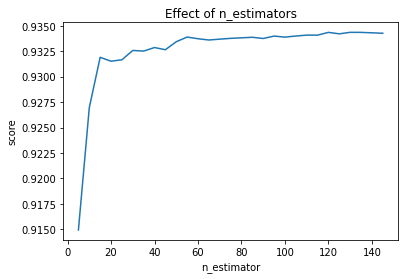

In [16]:
# Further hypertuning for quantitative parameters.
# Optimisation for n_estimators parameter.

estimators = np.arange(5, 150, 5)
scores = []
for n in estimators:
    rfr.set_params(n_estimators=n)
    rfr.fit(X_train, y_train)
    scores.append(rfr.score(X_test, y_test))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

In [17]:
# Set parameter to optimum and retest score.

rfr.set_params(n_estimators = 40)
rfr.fit(X_train, y_train)
print(rfr.score(X_test, y_test))

0.9328677170362311


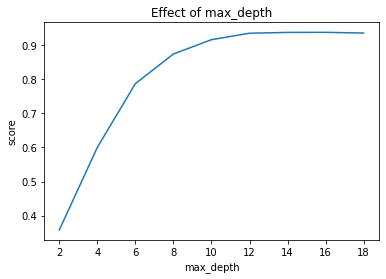

In [18]:
# Optimisation for max_depth parameter.

depth = np.arange(2, 20, 2)
scores = []
for n in depth:
    rfr.set_params(max_depth=n)
    rfr.fit(X_train, y_train)
    scores.append(rfr.score(X_test, y_test))
plt.title("Effect of max_depth")
plt.xlabel("max_depth")
plt.ylabel("score")
plt.plot(depth, scores)

In [19]:
# Set parameter to optimum and retest score.

rfr.set_params(max_depth = 14)
rfr.fit(X_train, y_train)
print(rfr.score(X_test, y_test))

0.936747404459622


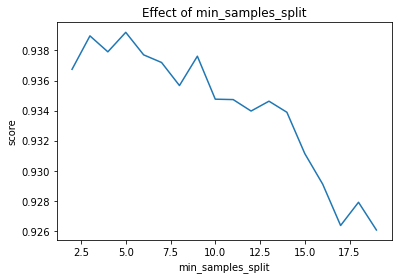

In [20]:
# Optimisation for min_samples_split parameter.

min_samples_split = np.arange(2, 20, 1)
scores = []
for n in min_samples_split:
    rfr.set_params(min_samples_split=n)
    rfr.fit(X_train, y_train)
    scores.append(rfr.score(X_test, y_test))
plt.title("Effect of min_samples_split")
plt.xlabel("min_samples_split")
plt.ylabel("score")
plt.plot(min_samples_split, scores)

In [21]:
# Set parameter to optimum and retest score.

rfr.set_params(min_samples_split = 10)
rfr.fit(X_train, y_train)
print(rfr.score(X_test, y_test))

0.9347614847961528


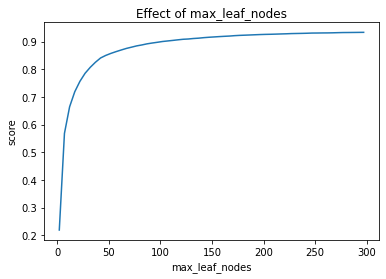

In [22]:
# Optimisation for max_leaf_nodes parameter.

max_leaf_nodes = np.arange(2, 302, 5)
scores = []
for n in max_leaf_nodes:
    rfr.set_params(max_leaf_nodes=n)
    rfr.fit(X_train, y_train)
    scores.append(rfr.score(X_test, y_test))
plt.title("Effect of max_leaf_nodes")
plt.xlabel("max_leaf_nodes")
plt.ylabel("score")
plt.plot(max_leaf_nodes, scores)

In [23]:
# Set parameter to optimum and retest score.

rfr.set_params(max_leaf_nodes = 200)
rfr.fit(X_train, y_train)
print(rfr.score(X_test, y_test))

rfr_pred = rfr.predict(X_test)

0.916166916398548


In [24]:
# Join 'X' and 'y' test df together along with predictions to make visualisations easier.
# Please note... only the test data.

y_test_df = y_test.to_frame()
y_test_df = y_test_df.rename(columns = {0:'mean_diameter'}).reset_index(drop=True)

pred_df = pd.DataFrame(rfr_pred, columns = ['predicted_mean_diameter']).reset_index(drop=True)
X_test_df = pd.DataFrame(X_test, columns = ['pp2m2', 'heat_units', 'solar_radiation', 'organic_matter', 'sand', 'silt', 'clay', 'method', 'variety', 'inputs', 'protection']).reset_index(drop = True)

test_df = X_test_df.copy()
test_df['predicted_mean_diameter'] = pd.Series(pred_df['predicted_mean_diameter'])
test_df['mean_diameter'] = pd.Series(y_test_df['mean_diameter'])

test_df[['method', 'variety', 'inputs', 'protection']] = enc.inverse_transform(test_df[['method',
                                                                                        'variety',
                                                                                        'inputs',
                                                                                        'protection']])

test_df.head()

,pp2m2,heat_units,solar_radiation,organic_matter,sand,silt,clay,method,variety,inputs,protection,predicted_mean_diameter,mean_diameter
0,76,1396,1241768,18.5,38,41,21,Drilled,Runner,Baby,None,14.615769,15.543158
1,28,2107,1265598,2.3,90,6,4,Bare Roots,Triton,Organic,None,22.831024,25.924286
2,34,813,522258,2.5,83,9,8,Bare Roots,Krypton,Conventional,None,13.188326,11.824706
3,45,2125,1344175,19.9,31,36,33,Drilled,Lexton,Conventional,Barley,22.205454,23.858667
4,17,1212,1234627,2.6,42,42,16,Drilled,Lancaster,Conventional,None,7.988745,6.440000


In [25]:
test_df.shape

(699, 13)

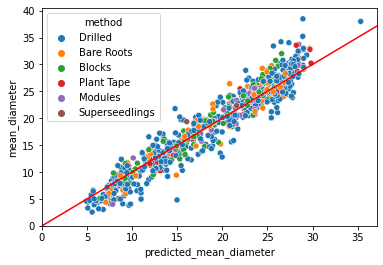

In [26]:
# Scatterplot to show how predicted mean compares to actual mean.
# Set hue to see if any indicator variables have a bias.

sns.scatterplot(y = 'mean_diameter', x = 'predicted_mean_diameter', hue = 'method', data = test_df)
plt.axline([0, 0], [1, 1], color = 'r')
plt.ylim(0)
plt.xlim(0)
plt.show()

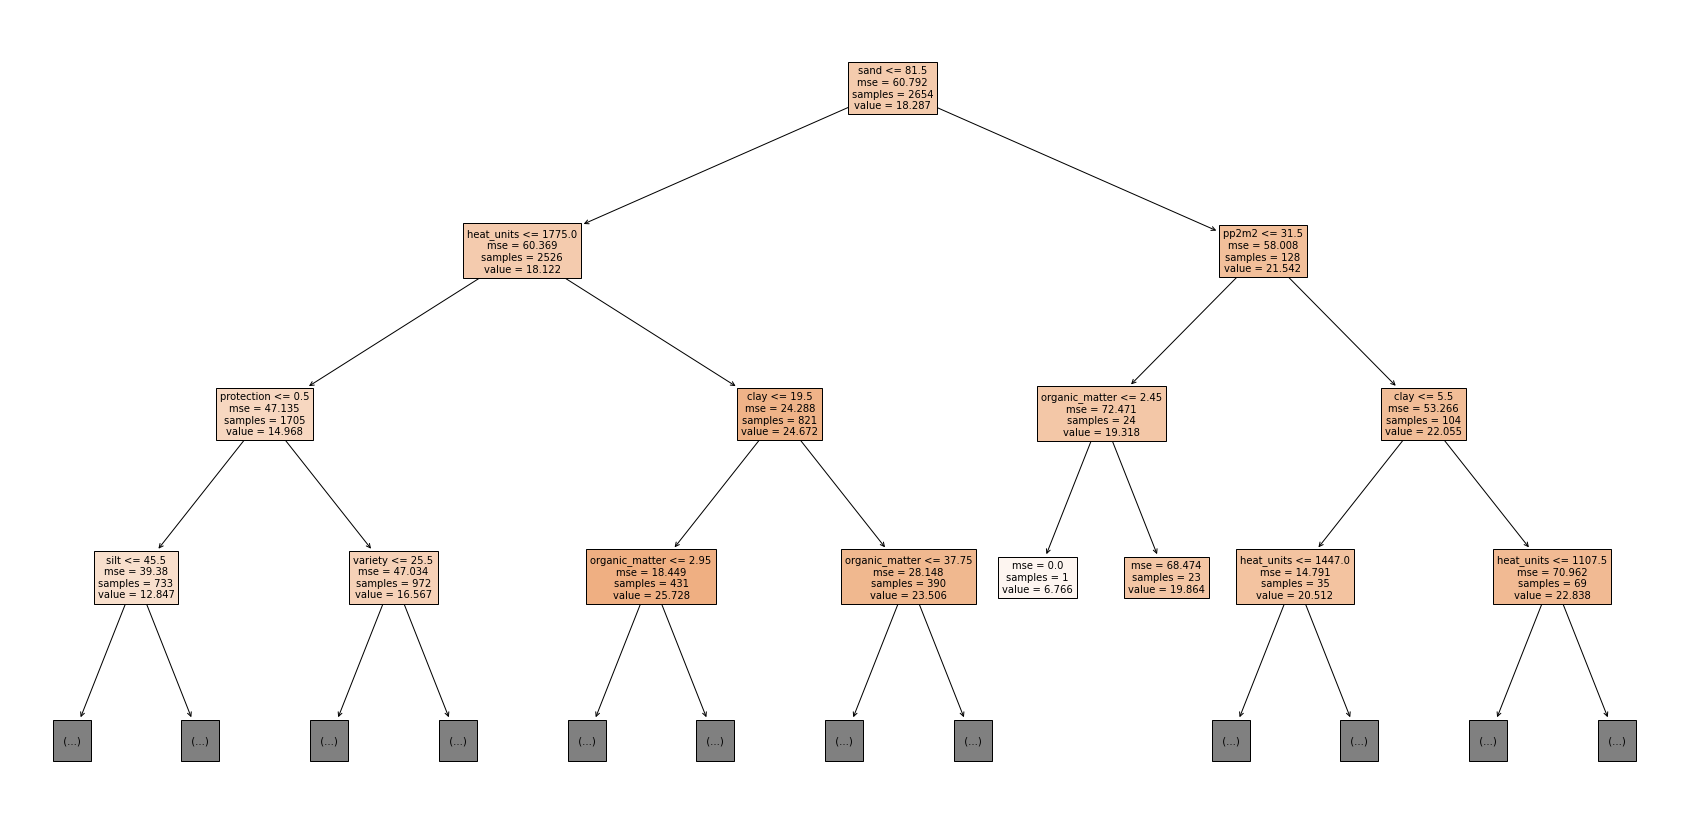

In [27]:
# Tree visualisation to depth of 3.
# Struggling to make visualisation go any deeper.

plt.figure(figsize=(30,15))
tree.plot_tree(rfr.estimators_[0], feature_names=X_train.columns, filled=True, max_depth = 3, fontsize=10)
plt.savefig('Decision Tree.png', dpi=300, bbox_inches = 'tight')
plt.show()

Text(0.5, 0, 'Feature Importance')

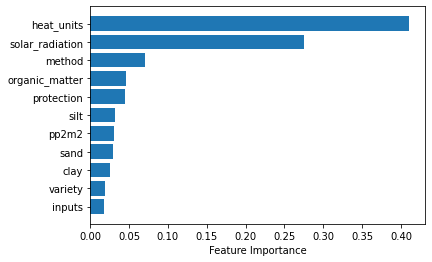

In [28]:
sort = rfr.feature_importances_.argsort()
plt.barh(np.array(X_test.columns)[sort], rfr.feature_importances_[sort])
plt.xlabel("Feature Importance")